# Mini-Transformer

Implementation of a Tiny Transformer for solving simple pattern matching tasks among numbers.

In order to implement a Transformer we need:
* Embedding, consisting of:
    * Token Embedding (standard look-up table)
    * Positional Embedding
* Attentions:
    * Multi-Head Attention
    * Scaled Dot-Product Attention
* Residual Connections and Normalization (Add & Norm Layer)
* Feed Forward Network

**IMPORTANT**: What we are actually implementing is not the original Transformer from the "Attention is All You Need" paper, but rather a modernized, decoder-only variant.
Either way, most of the main blocks are the same as the original.

![Transformer](img/transformer.png)

## Implementation of the Transformer

In [18]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [18]:
# Utility classes and functions

@dataclass
class Config:
    """A class to handle Configuration of the Transformer"""
    d_model: int = 4
    n_heads: int = 1  # single head for clarity
    d_ff: int = 8
    vocab_size: int = 10
    max_len: int = 8
    num_layers: int = 1
    device: str = "cpu"
    lr: float = 0.02
    steps: int = 200  # adjust if you want it faster/slower
    seed: int = 0


def causal_mask(seq_len):
    """
    Returns a Tensor that ensures that the Model only pays attention (attends) to tokens that came before, and not after.

    e.g. seq_len = 4:
    [[1, 0, 0, 0],
     [1, 1, 0, 0],
     [1, 1, 1, 0],
     [1, 1, 1, 1]]
    """
    mask = torch.ones(seq_len, seq_len, dtype=torch.bool).tril()
    return mask.view(1, 1, seq_len, seq_len)

In [19]:
cfg = Config()
torch.manual_seed(cfg.seed)

### Single Head Self-Attention

SingleHeadSelfAttention is a Module that computes the Single Head Scaled Dot-Product Attention.

The idea behind Scaled Dot-Product Attention is to determine which tokens (keys)
are more important to which other tokens (query). Consider a certain query (a token):
* We determine a similarity score between each key and the query.
* This score is then turned into the attention.
With this process, we now which of the previous encoder states should receive more
importance (attention) when processing a certain other token.

Attention is Trained by optimizing the values of the weights in the 3 matrices:
Q, K, V.

Formula for Attention, from the original paper, is:

$$
Attention(Q, K, V) = softmax(\dfrac{QK^T}{\sqrt{d_k}})V
$$

In [7]:
class SingleHeadSelfAttention(nn.Module):

    def __init__(self, d_model):
        super().__init__()

        # Q, K, V Weight Matrices (shaped as Linear NN Layers for GD & BP)
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

        # Final Transformation (as in the original paper)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.last_attn = None  # Just for visualization

    def forward(self, x, attn_mask=None, store_attn=False):
        B, T, D = x.shape # [Batch Size x Number of Tokens x Model Dimension]
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Compute scores (as in the original paper)
        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(D)  # Result is [B,T,T]
        if attn_mask is not None: # Eventually apply an attention mask
            scores = scores.masked_fill(~attn_mask.squeeze(1), float("-inf"))

        # Apply softmax (as in the original paper)
        attn = torch.softmax(scores, dim=-1)

        # Multiply by V (as in the original paper)
        out = attn @ V

        # Final Linear Transformation
        out = self.W_o(out)

        if store_attn:
            self.last_attn = attn[0].detach().cpu()
        return out

### Feed Forward

Both the Encoder and the Decoder of a Transformer are equipped with a Feed Forward 2-Layer Perceptron.

Its purpose is to add non-linearity (through the Activation Function **GELU**) to the computation



In [8]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x))) # Non-Linear Activation (variant of ReLu)

### Transformer Block

Transformer Block is a generic Transformer Layer, which could serve either the role of the Encoder of the Decoder.

Its structure, w.r.t. the original paper, is most similar to that of the Encoder. In particular, it performs:
* First Normalization
* Self-Attention (Scaled Dot-Product Attention)
* Second Normalization
* Feed Forward pass

Note that, with each Normalization, Residual Connections are used to avoid too drastic changes to the result.

**IMPORTANT**: in the original paper, the ordering of the layers is slightly different (Normalizations happens after SA and FFN).
This change was introduced later in the literature to increase training stability (no gradient explosion or vanishing).

In [9]:
class TinyTransformerBlock(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.sa = SingleHeadSelfAttention(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff)

    def forward(self, x, attn_mask=None, store_attn=False):
        x = x + self.sa(self.ln1(x), attn_mask=attn_mask, store_attn=store_attn)
        x = x + self.ffn(self.ln2(x))
        return x

### Transformer

The entire Tiny Transformer can be assembled using the previously defined blocks.

In [12]:
class TinyTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()

        # Embedding layers
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos_emb = nn.Embedding(cfg.max_len, cfg.d_model)  # Positional Embedding is learned

        # Internal layers
        self.blocks = nn.ModuleList([TinyTransformerBlock(cfg.d_model, cfg.d_ff) for _ in range(cfg.num_layers)])
        self.ln_f = nn.LayerNorm(cfg.d_model)

        # Final Linear transformation
        self.head = nn.Linear(cfg.d_model, cfg.vocab_size)

    def forward(self, idx, store_attn=False):
        B, T = idx.shape
        pos = torch.arange(T, device=idx.device).unsqueeze(0).expand(B, T)

        x = self.tok_emb(idx) + self.pos_emb(pos) # Embedding
        mask = causal_mask(T).to(idx.device) # Always use the Attention Mask (Self-Attention but never looking at the "future")

        for i, block in enumerate(self.blocks):
            x = block(x, attn_mask=mask, store_attn=(store_attn and i == len(self.blocks) - 1))

        x = self.ln_f(x)
        return self.head(x)

    def last_attention(self):
        return self.blocks[-1].sa.last_attn

## Training the Transformer on a Task

### 1st Task

We could start with a very simple task: always predict the successor natural number.

In [13]:
# Very tiny training set
base = torch.tensor([[0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6]], dtype=torch.long)
targets = torch.tensor([[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7]], dtype=torch.long)

In [20]:
model = TinyTransformer(cfg).to(cfg.device)
opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

# Training a Transformers is done just like any other Model
loss_history = []
for step in range(cfg.steps):
    logits = model(base, store_attn=(step == cfg.steps - 1))
    loss = F.cross_entropy(logits.view(-1, cfg.vocab_size), targets.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(loss.item())

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")  # Grows very fast
print(f"Final training loss: {loss_history[-1]:.4f}")

Total parameters: 286
Final training loss: 0.0054


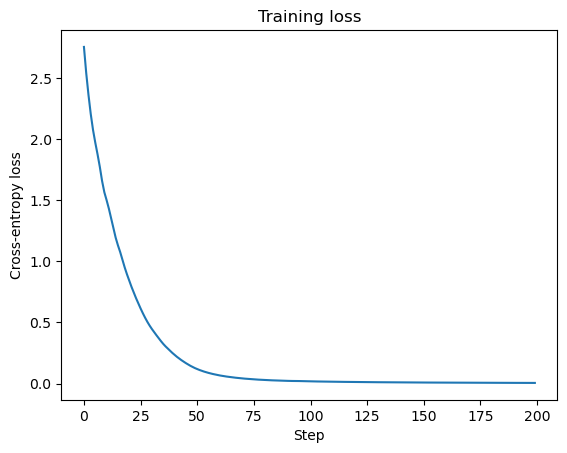

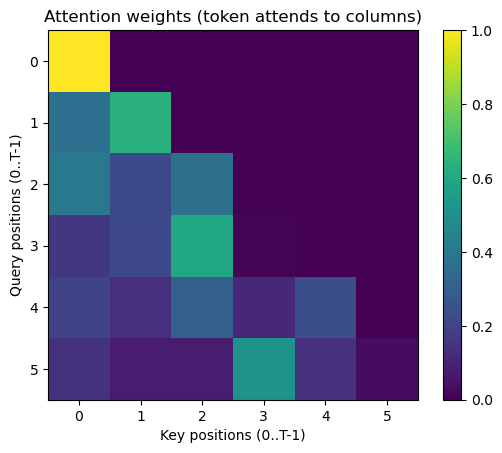

In [21]:
# 1) Loss curve
plt.figure()
plt.plot(loss_history)
plt.title("Training loss")
plt.xlabel("Step")
plt.ylabel("Cross-entropy loss")
plt.show()

# 2) Attention heatmap from last forward pass
attn = model.last_attention()
if attn is not None:
    plt.figure()
    plt.imshow(attn)
    plt.title("Attention weights (token attends to columns)")
    plt.xlabel("Key positions (0..T-1)")
    plt.ylabel("Query positions (0..T-1)")
    plt.colorbar()
    plt.show()
else:
    print("No stored attention to visualize.")

### Task Results

Picking this task was not a good idea, for at least a couple of reasons:
* We do not have ambiguity in the next token (in the training set)
* Most importantly, we only really care about the previous word, not the entire sequence
  * Attention is not really needed!

(We can see from the Attention Heatmap that we are basically looking at the last token only)



### 2nd Task

We can imagine of a more complex sequence, which does not limit to the previous token.

In [22]:
# Very tiny training set
base = torch.tensor([[0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6]], dtype=torch.long)
targets = torch.tensor([[2, 3, 4, 5, 6, 8], [3, 4, 5, 6, 8, 9]], dtype=torch.long)

In [23]:
model = TinyTransformer(cfg).to(cfg.device)
opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

# Training a Transformers is done just like any other Model
loss_history = []
for step in range(cfg.steps):
    logits = model(base, store_attn=(step == cfg.steps - 1))
    loss = F.cross_entropy(logits.view(-1, cfg.vocab_size), targets.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(loss.item())

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")  # Grows very fast
print(f"Final training loss: {loss_history[-1]:.4f}")

Total parameters: 286
Final training loss: 0.0038


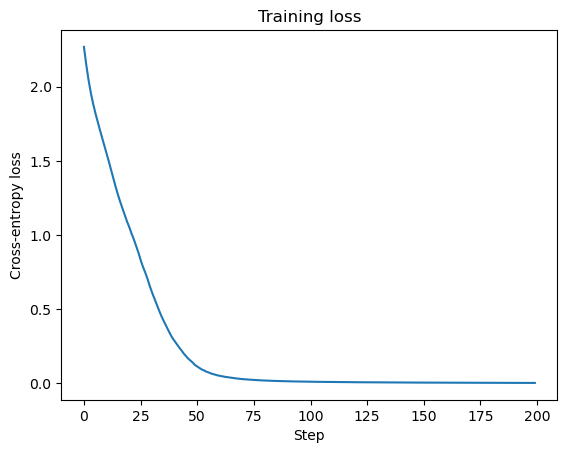

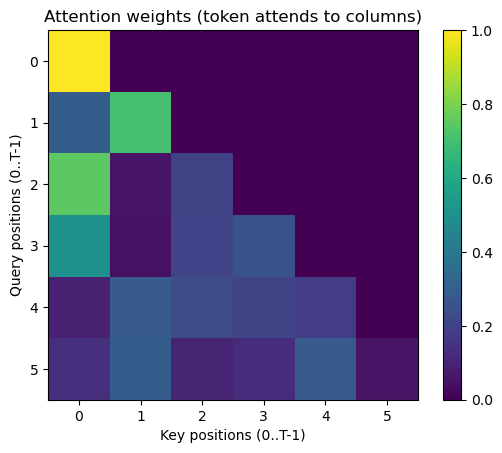

In [24]:
# 1) Loss curve
plt.figure()
plt.plot(loss_history)
plt.title("Training loss")
plt.xlabel("Step")
plt.ylabel("Cross-entropy loss")
plt.show()

# 2) Attention heatmap from last forward pass
attn = model.last_attention()
if attn is not None:
    plt.figure()
    plt.imshow(attn)
    plt.title("Attention weights (token attends to columns)")
    plt.xlabel("Key positions (0..T-1)")
    plt.ylabel("Query positions (0..T-1)")
    plt.colorbar()
    plt.show()
else:
    print("No stored attention to visualize.")

### Task Results

We can see that some variety appeared in the Attention Heatmap

